In [ ]:
pip install -U scikit-learn

In [ ]:
import pandas as pd
from pathlib import PurePath
import numpy as np
import data_construction as dc
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

In [ ]:
# file
clean_data = 'cleaned_full_data.csv'

# import data
df = pd.read_csv(clean_data, index_col=0)

# interpolate and join
test = dc.det_interp(df.iloc[:,1])
econ_interp = df.iloc[:,:-1].apply(dc.det_interp, axis=0)
df = pd.concat([econ_interp, df.iloc[:,-1]], axis=1, join="outer")

# perform time lags
df['SVENY10_1'] = df['SVENY10'].shift(1)
df['SVENY10_60'] = df['SVENY10'].shift(60)
df_lag_1 = df.iloc[:,:-1].dropna().drop(['SVENY10'], axis=1)
df_lag_60 = df.drop(['SVENY10_1', 
    'SVENY10'], axis=1).dropna()
df = df.iloc[:,:-2]

# test vs train
tscv = TimeSeriesSplit(n_splits=5, test_size=60)

In [ ]:
df_arima = df.iloc[:, [-1]]
df_arima_train = df_arima.iloc[df_arima.shape[0] - 100:-10, :]
df_arima_test = df_arima.iloc[-10:, :]

In [ ]:
result = adfuller(df_arima_train['SVENY10'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -1.5550988866886077
p-value: 0.5061002558006085


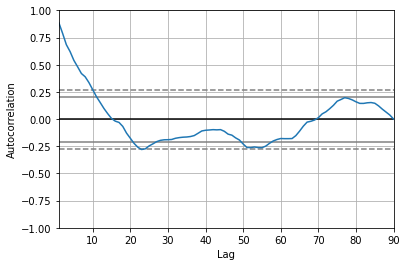

In [ ]:
autocorrelation_plot(df_arima_train)
# p value = 10

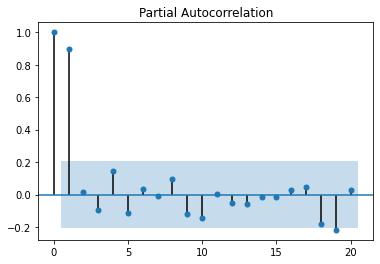

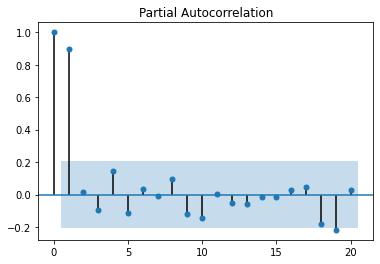

In [ ]:
plot_pacf(df_arima_train, lags=20)

# q value = 2

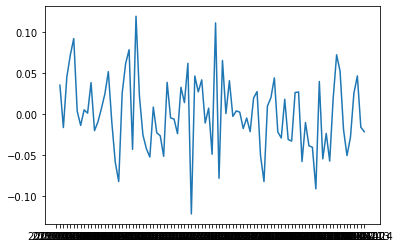

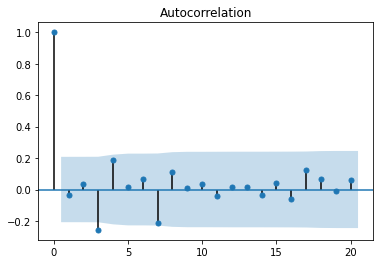

In [ ]:
# df_log = np.log(df_arima_train)
plt.plot(df_arima_train['SVENY10'].diff())
plot_acf(df_arima_train['SVENY10'].diff().dropna())
plt.show()

In [ ]:
model = ARIMA(df_arima_train['SVENY10'], order=(10,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.SVENY10   No. Observations:                   89
Model:                ARIMA(10, 1, 1)   Log Likelihood                 156.623
Method:                       css-mle   S.D. of innovations              0.041
Date:                Tue, 03 Aug 2021   AIC                           -287.247
Time:                        10:46:56   BIC                           -254.894
Sample:                             1   HQIC                          -274.206
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0010      0.004      0.219      0.827      -0.008       0.010
ar.L1.D.SVENY10     -0.7160      0.296     -2.416      0.018      -1.297      -0.135
ar.L2.D.SVENY10      0.0838 

,0
count,89.000000
mean,-0.000013
std,0.041876
min,-0.101248
25%,-0.022070
50%,0.004884
75%,0.023722
max,0.124265


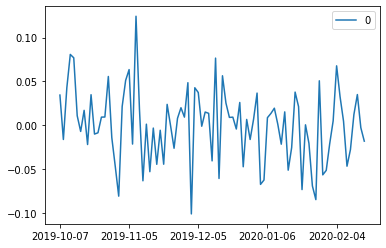

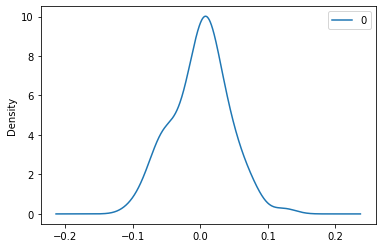

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
residuals.describe()

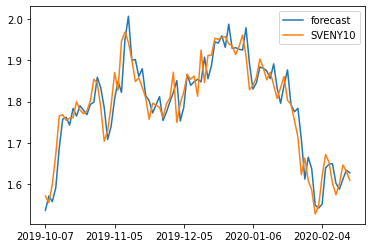

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()


In [ ]:
fc, se, conf = model_fit.forecast(10, alpha=0.02) 

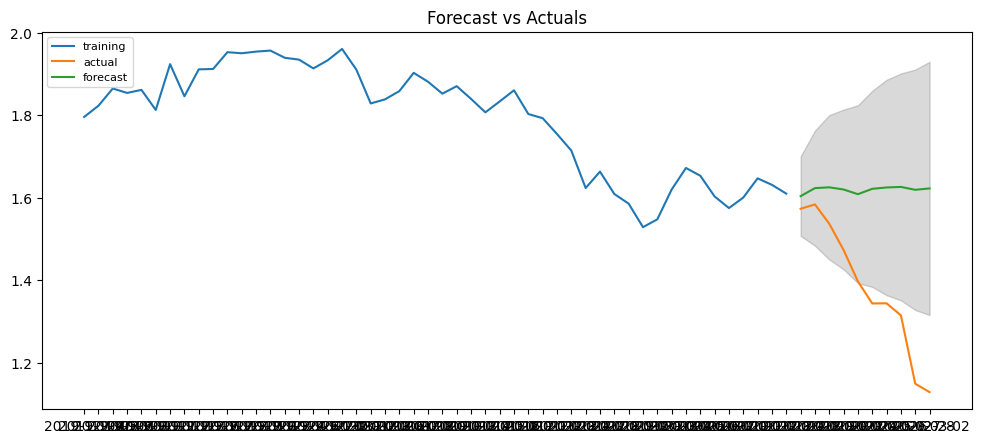

In [ ]:
fc_series = pd.Series(fc, index=df_arima_test.index)
lower_series = pd.Series(conf[:, 0], index=df_arima_test.index)
upper_series = pd.Series(conf[:, 1], index=df_arima_test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_arima_train.iloc[-50:,:], label='training')
plt.plot(df_arima_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()